In [1]:
import os
import pymssql

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from dotenv import load_dotenv

load_dotenv()

def get_connection(db='processo'):
    return pymssql.connect(
        server=os.getenv("SQL_SERVER_HOST"),
        user=os.getenv("SQL_SERVER_USER"),
        password=os.getenv("SQL_SERVER_PASS"),
        port=os.getenv("SQL_SERVER_PORT"),
        database=db
    )



from langchain_openai import AzureOpenAI, AzureChatOpenAI
from langchain.prompts import PromptTemplate, ChatPromptTemplate, FewShotChatMessagePromptTemplate

llm = AzureChatOpenAI(model_name="gpt-4o")


In [2]:
sql_decisoes = """ 
SELECT CONCAT(acp.numero_processo, '/', acp.ano_processo) as processo, 
t.codigo as tipo_processo,
t.descricao as descricao_tipo_processo,
acp.* 
FROM processo.dbo.Ata_Composicao_Pautas acp 
	INNER JOIN processo.dbo.Processos pro 
	ON acp.numero_processo = pro.numero_processo AND acp.ano_processo = pro.ano_processo
	INNER JOIN processo.dbo.Tipo t
	ON t.codigo = pro.codigo_tipo_processo

WHERE ( year(acp.DataInclusao) = 2024 AND month(acp.DataInclusao) IN (10, 11, 12) )
"""
df_decisoes_20244 = pd.read_sql(sql_decisoes, get_connection())

sql_decisoes = """ 
SELECT CONCAT(acp.numero_processo, '/', acp.ano_processo) as processo, 
t.codigo as tipo_processo,
t.descricao as descricao_tipo_processo,
acp.* 
FROM processo.dbo.Ata_Composicao_Pautas acp 
	INNER JOIN processo.dbo.Processos pro 
	ON acp.numero_processo = pro.numero_processo AND acp.ano_processo = pro.ano_processo
	INNER JOIN processo.dbo.Tipo t
	ON t.codigo = pro.codigo_tipo_processo

WHERE ( year(acp.DataInclusao) = 2025 AND month(acp.DataInclusao) IN (1, 2, 3) )
"""
df_decisoes_20251 = pd.read_sql(sql_decisoes, get_connection())


/tmp/ipykernel_7914/636333705.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes_20244 = pd.read_sql(sql_decisoes, get_connection())
/tmp/ipykernel_7914/636333705.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes_20251 = pd.read_sql(sql_decisoes, get_connection())


In [3]:
len(df_decisoes_20244), len(df_decisoes_20251)

(979, 1061)

In [4]:
retirar_tipos = ['APO', 'NCE', 'PEN', 'INM', 'ASS', 'FCO']
df_decisoes_20251 = df_decisoes_20251[~df_decisoes_20251.tipo_processo.isin(retirar_tipos)]

In [5]:
df_decisoes_20251.columns

Index(['processo', 'tipo_processo', 'descricao_tipo_processo',
       'IdComposicaoPauta', 'codigo_camara', 'numero_sessao', 'ano_sessao',
       'numero_processo', 'ano_processo', 'ordem_informacao', 'setor',
       'resumo', 'parecer_proc', 'voto', 'interessado', 'assunto', 'usuario',
       'data_ultima_atualizacao', 'acordaos', 'Pro_saiu_num_sessao',
       'Pro_saiu_ano_sessao', 'Pro_remanescente_num_sessao',
       'Pro_remanescente_ano_sessao', 'Relator', 'Relator_substituido',
       'titulo_detalhe', 'texto_detalhe', 'ordemInformacaoProc', 'setorProc',
       'ordemInformacaoVoto', 'setorVoto', 'resumoVoto', 'resultadoTipo',
       'numeroResultado', 'anoResultado', 'resultado', 'ementa',
       'arquivoFisico', 'cabecalhoAcordao', 'rodapeAcordao', 'idInformacao',
       'idSessao', 'dataInclusao', 'usuarioInclusao',
       'processoLiberadoPublicacao', 'dataGeracaoArquivoPublicacao',
       'usuarioGeracaoArquivoPublicacao', 'DataPublicacaoDOE',
       'UsuarioInclusaoPublica

/tmp/ipykernel_7914/517152994.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_data.index, y=grouped_data.values, palette="viridis")


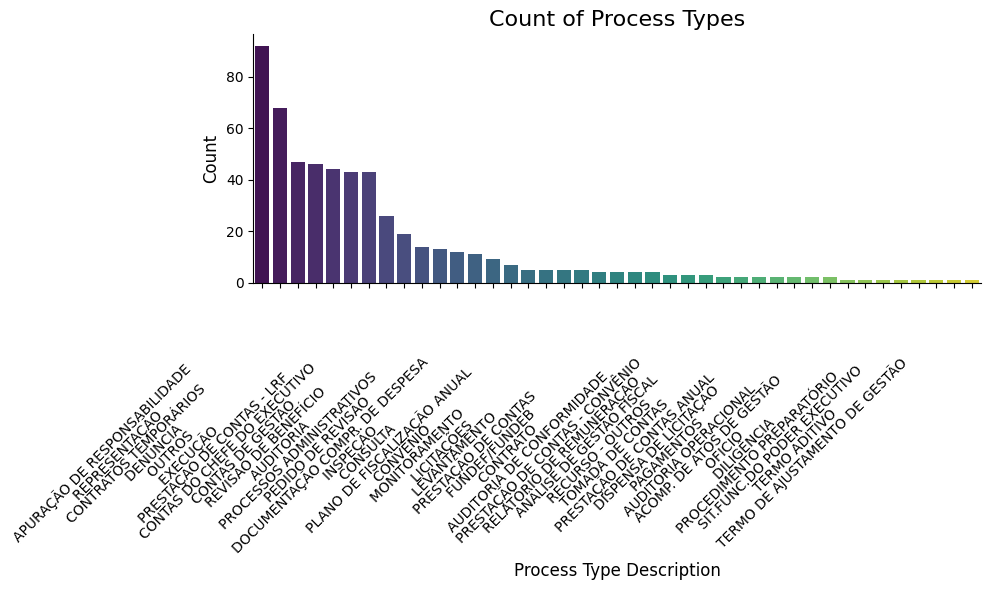

In [6]:
# Grouping the data by 'descricao_tipo_processo' and calculating the size
grouped_data = df_decisoes_20251.groupby('descricao_tipo_processo').size()

grouped_data.sort_values(ascending=False, inplace=True)

# Creating a seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.index, y=grouped_data.values, palette="viridis")

# Customizing the plot
plt.title('Count of Process Types', fontsize=16)
plt.xlabel('Process Type Description', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Removing the upper and right spines
sns.despine(top=True, right=True)

# Display the plot
plt.tight_layout()
plt.show()

In [7]:
for d in df_decisoes_20251['descricao_tipo_processo'].unique():
    print(d)

CONTRATOS TEMPORÁRIOS                             
DENÚNCIA                                          
PRESTAÇÃO DE CONTAS - LRF                         
CONTAS DO CHEFE DO EXECUTIVO                      
EXECUÇÃO                                          
APURAÇÃO DE RESPONSABILIDADE                      
PRESTAÇÃO DE CONTAS                               
LICITAÇÕES                                        
REPRESENTAÇÃO                                     
OUTROS                                            
REVISÃO DE BENEFÍCIO                              
MONITORAMENTO                                     
TERMO ADITIVO                                     
PLANO DE FISCALIZAÇÃO ANUAL                       
INSPEÇÃO                                          
ANÁLISE DE GESTÃO FISCAL                          
CONTAS DE GESTÃO                                  
PROCESSOS ADMINISTRATIVOS                         
TOMADA DE CONTAS                                  
DOCUMENTAÇÃO COMPR. DE DESPESA 

In [8]:
df_decisoes_20251

,processo,tipo_processo,descricao_tipo_processo,IdComposicaoPauta,codigo_camara,numero_sessao,ano_sessao,numero_processo,ano_processo,ordem_informacao,...,UsuarioLiberadoPublicacaoMonocratica,IdMotivoRetirada,IdApreciacao,idTipoRecurso,IdTipoVotacao,POssuiObrigacao,IdTipoIrregularidade,PlenarioVirtualVistasMPC,PlenarioVirtualSustentacaoOralMpc,ContemVotoVista
0,105093/2023,CTT,CONTRATOS TEMPORÁRIOS ...,118618,3,0002V,2025,105093,2023,0012,...,None,NaN,2.0,NaN,1.0,False,NaN,None,None,None
2,000499/2016,DEN,DENÚNCIA ...,118758,3,0002V,2025,000499,2016,0008,...,None,NaN,2.0,NaN,1.0,False,NaN,None,None,None
3,000500/2016,DEN,DENÚNCIA ...,118759,3,0002V,2025,000500,2016,0009,...,None,NaN,2.0,NaN,1.0,False,NaN,None,None,None
4,700883/2012,LRF,PRESTAÇÃO DE CONTAS - LRF ...,118930,3,0004V,2025,700883,2012,0068,...,None,NaN,3.0,4.0,1.0,False,NaN,None,None,None
6,005926/2013,REL,CONTAS DO CHEFE DO EXECUTIVO ...,118535,3,00001,2025,005926,2013,0022,...,None,2.0,NaN,NaN,NaN,False,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,004362/2023,REL,CONTAS DO CHEFE DO EXECUTIVO ...,119377,2,0005v,2025,004362,2023,0003,...,None,1.0,NaN,NaN,NaN,False,NaN,None,None,None
1045,000248/2024,REP,REPRESENTAÇÃO ...,119378,2,0007V,2025,000248,2024,0007,...,None,NaN,NaN,NaN,NaN,False,NaN,None,None,None
1051,101315/2024,CTT,CONTRATOS TEMPORÁRIOS ...,119410,3,00004,2025,101315,2024,0005,...,None,NaN,2.0,NaN,1.0,False,NaN,None,None,None
1057,102597/2024,RBN,REVISÃO DE BENEFÍCIO ...,119396,3,0005V,2025,102597,2024,None,...,None,NaN,NaN,NaN,NaN,False,NaN,None,None,None


In [9]:
df_decisoes = df_decisoes_20251[~df_decisoes_20251['resultado'].isna()]

In [10]:
len(df_decisoes)

328

In [21]:
def classify_decision(text):
    examples = [
        {
            "input": """
            - Adoção das providências cabíveis no tocante aos indícios de impropriedades /irregularidades
    elencadas na tabela 19 do Relatório (transcritas acima ), com fundamento no art. 2º, inciso III, da
    Resolução nº 012/2023-TCE, notadamente para que a Secretaria de Controle Externo analise a
    capacidade operacional desta Corte com vistas ao acompanhamento e /ou à abertura de processo
    autônomo, respeitadas a conveniência e oportunidade, referente aos itens 4.2 (Divergência dos
    dados do planejamento do Projeto, Inconsistência dos saldos da conta bens móveis entre os
    registros do SIGEF - Sistema Integrado de Planejamento e Gestão Fiscal - e SMI - Sistema de
    Monitoramento e Informações do Projeto - e deficiências na elaboração das notas explicativas ),
    5.5.1.1 (Inventário físico ), 5.6.1.1 ( Falhas/deficiências construtivas do Hospital Regional da
    Mulher Parteira Maria Correia) e 5.6.1.3 (Pendências de legalização das obras da Biblioteca
    Câmara Cascudo e da Sede do Serviço Nacional de Emprego – SINE).""",
            "output": "OBRIGACAO"}, {
            "input": """( a.i) promovam, no prazo de 120 (cento e vinte dias) úteis, contados a partir da intimação da
    presente Decisão, a apuração dos fatos e se verifique a constitucionalidade e legalidade dos
    vínculos funcionais de cada servidor que figura nos Anexos nºs. 01 e 02 contidos nos Eventos
    nºs. 04 e 05, além de outros que porventura sejam informados pela DDP em cumprimento ao
    item b, por meio da instauração de processos administrativos disciplinares individuais ,
    regulados pela Lei que trata do Estatuto Jurídico dos Servidores do respectivo Município ,
    com observância dos princípios do contraditório, ampla defesa e devido processo legal;
        ( a.ii) comprovem neste feito, em 05 dias úteis após ultimado o prazo de definição dos PAD
    ´s, as conclusões de todos os processos administrativos instaurados, no tocante à eliminação
    de tríplice vínculo funcional identificado e de enquadramento das eventuais acumulações
    dúplices nas hipóteses permitidas pela Constituição Federal, com a respectiva
    compatibilidade de horários, sob pena de, não cumprindo tais obrigações nos prazos antes
    referidos, incidir em multa diária e pessoal ao gestor, no valor de R$ 500,00, com espeque no
    art. 110 da LCE nº 464/2012 c/c o art. 326 do RITCE, cabendo à Diretoria de Despesa com
    Pessoal monitorar o cumprimento da presente Decisão;""",
            "output": "OBRIGACAO"}, {
            "input": """Vistos, relatados e discutidos estes autos, em consonância ao posicionamento do
    Corpo técnico e do Ministério Público de Contas, ACORDAM os Conselheiros, nos termos
    do voto proposto pelo Conselheiro Relator, julgar a inadmissibilidade da presente denúncia e
    o seu conseqüente arquivamento, com fulcro nos art. 12 do Provimento 002/2020 –
    CORREG/TCE, aprovado pela Resolução 016/2020 – TCE e artigo 80, § 1º, da LOTCE.
    E ainda, Pela expedição de RECOMENDAÇÃO, nos termos do art. 301, III da Resolução
    009/2012 (RITCE/RN) c/c art. 13, II da Resolução 16/2020 –TCE/RN, ao Executivo
    Municipal de Nísia Floresta /RN, com cópia para o respectivo órgão de controle interno, ou
    setor responsável pelas publicações oficiais, lastreada na Constituição Federal de 88/ Art. 37,
    a fim de que promova e deixe claro os seguintes comportamentos em suas postagens""",
            "output": "OBRIGACAO"}, {
            "input": """
    Ante o exposto, discordando do Corpo Técnico da DAM e do Ministério Público de Contas – que se manifestaram no sentido de julgar o mérito do feito pela aprovação da matéria – VOTO no sentido de:
    1) preliminarmente, considero inexistentes os documentos constantes no processo apensado n. 300799/2024, na forma do art. 166, § 2º, do RITCE;
    2) rejeitar a preliminar de incompetência desta Corte de Contas para a análise das contratações objeto dos autos;
    3) nos termos dos arts. 120 e 121 da LCE nº 464/2012, conceder, de ofício, tutela provisória (medida cautelar) para determinar aos atuais gestores dos Municípios de Lagoa Nova/RN, Cruzeta/RN e Jucurutu/RN, que:
    a) tão logo sejam intimados, suspendam de forma imediata os pagamentos de honorários advocatícios em favor de Fernanda de Paula Sociedade Individual de Advocacia, decorrentes dos Contratos objeto dos autos, ainda que encerrada a sua vigência, ou de termos aditivos destes, acaso existentes, até o julgamento de mérito do presente feito, sob pena de multa pessoal ao gestor recalcitrante no valor de R$ 50.000,00 (cinquenta mil reais) por cada novo pagamento realizado;
    b) assim que forem intimados, promovam, também de forma imediata e por meio de ato formal, a habilitação das Procuradorias de cada um dos Municípios nos autos dos processos administrativos e/ou judiciais nos quais Fernanda de Paula Sociedade Individual de Advocacia representa os Entes municipais;
    c) no prazo de 10 (dez) dias úteis, a contar de sua intimação, comprovem nestes autos o exato cumprimento das medidas cautelares ora determinadas, especialmente no que tange à suspensão imediata dos pagamentos e à habilitação, também imediata, das Procuradorias nos processos que Fernanda de Paula Sociedade Individual de Advocacia representa os respectivos Entes municipais. No mesmo prazo, devem juntar ao presente feito eventuais termos aditivos realizados com Fernanda de Paula Sociedade Individual de Advocacia, ou comprovar que não houve, sob pena de multa pessoal ao gestor recalcitrante no valor de R$ 5.000,00 (cinco mil reais) por cada dia de eventual descumprimento destas ordens, na forma do art. 110, da LCE nº 464/2012;
    d) com base no art. 82, inciso V, da Lei Complementar Estadual n. 464/12, e no art. 288, do Regimento Interno do TCE/RN, pela determinação do MONITORAMENTO do cumprimento da presente Decisão, por intermédio da DAM;
    4) a citação dos Srs. Iogo Nielson de Queiroz e Silva, Luciano Silva Santos e Joaquim José de Medeiros, Prefeitos Municipais de Jucurutu/RN, Lagoa Nova/RN e Cruzeta/RN, respectivamente, além de Fernanda de Paula Sociedade Individual de Advocacia, com arrimo nos artigos 37, c/c 45, §1º, inciso II, ambos da Lei Complementar Estadual nº 464/2012, a fim de que, querendo, apresentem suas razões de defesa;
    5) a remessa imediata de cópia da decisão ora proferida ao Ministério Público Comum Estadual, haja vista a probabilidade de dano ao erário em razão dos pagamentos já realizados e que seguem acontecendo, possibilitando-lhe o conhecimento para eventuais providências no âmbito de sua competência.
    Intimem-se da forma mais célere possível, nos termos do art. 46, § 4º da LCE 464/2012, além dos atuais gestores dos Municípios de Lagoa Nova/RN, Cruzeta/RN e Jucurutu/RN, também a Representada Fernanda de Paula Sociedade Individual de Advocacia.
    Sala das Sessões, data da assinatura eletrônica.

    (assinado digitalmente)
    Carlos Thompson Costa Fernandes
    Conselheiro Relator
    """,
            "output": "OBRIGACAO"}, {
            "input": """
            Pelo exposto, concordando parcialmente com o Representante e em dissonância com o Ministério Público de Contas – divirjo do Representante em relação ao prazo proposto e deste último por entender pelo deferimento do pedido cautelar e não pela citação da gestora –, VOTO:

    a) pelo acolhimento em parte do pedido cautelar apontado no item “b” da Exordial, ao passo que determino a intimação do Município de Tenente Ananias/RN e de sua gestora para que:

    (a.i) promovam, no prazo de 120 (cento e vinte dias) úteis, contados a partir da intimação da presente Decisão, a apuração dos fatos e se verifique a constitucionalidade e legalidade dos vínculos funcionais de cada servidor que figura na Informação Técnica da DDP junto ao evento nº 33, por meio da instauração de processos administrativos disciplinares individuais, regulados pela Lei que trata do Estatuto Jurídico dos Servidores do respectivo Município, com observância dos princípios do contraditório, ampla defesa e devido processo legal;

    (a.ii) comprovem neste feito, em 05 dias úteis após ultimado o prazo de definição dos PAD´s, as conclusões de todos os processos administrativos instaurados, no tocante à eliminação de tríplice vínculo funcional identificado e de enquadramento das eventuais acumulações dúplices nas hipóteses permitidas pela Constituição Federal, com a respectiva compatibilidade de horários, sob pena de, não cumprindo tais obrigações nos prazos antes referidos, incidir em multa diária e pessoal à gestora, no valor de R$ 500,00, com espeque no art. 110 da LCE nº 464/2012 c/c o art. 326 do RITCE, cabendo à Diretoria de Despesa com Pessoal monitorar o cumprimento da presente Decisão;

    b) com base no art. 82, inciso V, da Lei Complementar Estadual nº 464/12, e no art. 288 do Regimento Interno do TCE/RN, pela determinação do MONITORAMENTO do cumprimento da presente Decisão, por intermédio da DDP.


    (assinado digitalmente)
    Carlos Thompson Costa Fernandes
    Conselheiro Relator
            """,
            "output": "OBRIGACAO"},{
                "input": """Vistos, relatados e discutidos estes autos, acolhendo os fundamentos do parecer
    ministerial, com substrato no art. 209 V da norma regimental, ACORDAM os Conselheiros ,
    nos termos do voto proposto pela Conselheira Relatora, julgar pelo ARQUIVAMENTO dos
    autos.""",
                "output": "OUTROS",
            },
            {
                "input": """Vistos, relatados e discutidos estes autos, ACORDAM os Conselheiros,  com o
    impedimento do Conselheiro Presidente Renato Costa Dias, nos termos do voto profposto
    pela Conselheira Relatora, haja vista os fundamentos fático -jurídicos explanados no excerto
    antecedente, comprovado documentalmente o adimplemento substancial do plano de
    redimensionamento/adequação do sistema de ensino natalense, julgar pela EXTINÇÃO do
    FEITO nos termos do art. 71 da Lei Complementar (estadual) c/c art. 22 §1° da LINDB e art .
    209 V da regra regimental.""",
                "output": "OUTROS",
            },
            {
                "input": """Vistos, relatados e discutidos estes autos, em consonância com o posicionamento da
    Diretoria de Administração Municipal – DAM e do Ministério Público de Contas ,
    ACORDAM os Conselheiros, nos termos do voto proferido pelo Conselheiro Relator, julgar
    pelo reconhecimento da incidência da Prescrição Intercorrente sobre a pretensão punitiva e
    ressarcitória desta Corte de Contas, nos termos do artigo 111, parágrafo único, da Lei
    Complementar Estadual nº 464/2012, com o consequente arquivamento dos presentes autos.
    E ainda, pelo envio de cópia das principais peças dos autos ao Ministério Público Estadual ,
    para conhecimento e atuação no âmbito de sua competência.""",
                "output": "OUTROS",
            },
            {
                "input": """Vistos, relatados e discutidos estes autos, em dissonância com o Ministério Público
    de Contas, ACORDAM os Conselheiros, nos termos do voto proferido pelo Conselheiro
    Relator, julgar pela extinção do feito, sem julgamento de mérito, com o consequente
    ARQUIV AMENTO dos autos, em virtude da incompatibilidade entre a emissão de parecer
    prévio pela aprovação com ressalvas das contas de governo e a instauração de apuração de
    responsabilidade para aplicação de sanções.""",
                "output": "OUTROS",
            }
        ]

    example_prompt = ChatPromptTemplate.from_messages([
            ("human", '''
            {input} '''),
            ("ai", "{output}"),
        ])

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt,
        examples=examples,)

    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """Você é um classificador de decisões de um tribunal de contas.
            Sua tarefa é definir se uma decisão trata de uma multa ou obrigação
            de fazer.

            Responda com DETERMINACAO se o texto contiver o termo "multa" e alguma recomendação ou obrigação de fazer
            Responda com OUTROS se o texto tratar de arquivamento, extinção do feito ou prescrição da matéria, ou outro assunto que não seja DETERMINACAO

            Responda APENAS com DETERMINACAO ou OUTROS."""),
            few_shot_prompt,
            ("human", "{input}"),])
    
    chain = final_prompt | llm
    decision_type = chain.invoke({"input": text}).content
    return decision_type

In [12]:
df_decisoes_20251['resultado'].fillna('', inplace=True)

/tmp/ipykernel_7914/2252146709.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_decisoes_20251['resultado'].fillna('', inplace=True)


In [13]:
teste = df_decisoes_20251.iloc[0]['resultado']

In [14]:
df_decisoes_20251[['resultado']]

,resultado
0,"Por todo o exposto, nos termos da informação d..."
2,"CONCLUSÃO:\r\n\r\nAnte o exposto, em consonânc..."
3,"CONCLUSÃO:\r\n\r\nAnte o exposto, em consonânc..."
4,"17.\tDiante do exposto, em consonância com o P..."
6,
...,...
1043,
1045,
1051,"37.\tDiante do exposto, divergindo do Ministér..."
1057,


In [ ]:
classify_decision(teste)

'OUTROS'

In [16]:
print(teste)

Por todo o exposto, nos termos da informação da unidade instrutiva e do parecer ministerial (eventos 21 e 27), sou pelo registro do ato de contratação temporária nos termos do art. 71 III da Constituição da República c/c art. 95 I da LC nº 464/2012.
Mais: por ampla divulgação do que for decidido pelo colegiado em atenção à efetividade do direito fundamental individual de acesso à informação (art. 5º XXXIII da Lei Política vigente). 


Ana Paula de Oliveira Gomes
R E L A T O R A

(DATADO E ASSINADO DIGITALMENTE)



In [34]:
teste_obrigacao = df_decisoes_20251[df_decisoes_20251['resultado'].str.contains('promov', case=False, na=False)].sample(1)['resultado'].values[0]

In [41]:
teste_obrigacao = df_decisoes_20251[df_decisoes_20251['resultado'].str.contains('promov', case=False, na=False)].sample(3)['resultado'].values[0]

In [42]:
print(teste_obrigacao)

42.	Diante do exposto, VOTO de forma preliminar, pela declaração, de ofício, da competência deste Tribunal para processar e julgar o presente caso, relativo à prestação de contas de gestor Municipal, no esteio da Questão de Ordem decidida pelo Tribunal Pleno, em 04 de julho de 2017, nos autos do Processo nº 011806/2008 – TC, bem como no entendimento do Supremo Tribunal Federal (ADPF 982/PR).
43.	No mérito, em consonância com a Unidade Técnica e discordando parcialmente do MPC, o qual requereu a citação do gestor para possibilitar a aplicação de multa a que se refere o art. 107, inciso II, alínea “e” da LCE nº 464/12, VOTO pela PROCEDÊNCIA DA REPRESENTAÇÃO, com adoção das seguintes medidas:
a)	aplicação de multa no valor de R$ 20.585,16 (vinte mil, quinhentos e oitenta e cinco reais e dezesseis centavos) ao Sr. Maciel Gomes da Silva, gestor da Prefeitura Municipal de Senador Eloi de Souza à época, em razão do ausência de repasses regulares das contribuições previdenciárias ao Regime Pró

In [43]:
classify_decision(teste_obrigacao)

'DETERMINACAO'

## Extração de dados

In [30]:
from typing import Optional, List
from pydantic import BaseModel, Field

class Obrigacao(BaseModel):
    """Determinação de obrigação, com valor e responsável"""
    responsavel: str = Field(description="Nome do órgão ou gestor responsável pela obrigação")
    prazo: str = Field(description="Prazo para cumprimento da obrigação")
    valor: Optional[float] = Field(description="Valor da multa, se houver")
    descricao: str = Field(description="Texto descritivo da obrigação")

class Recomendacao(BaseModel):
    """Recomendação do TCE/RN"""
    descricao: str = Field(description="Texto descritivo da recomendação")
    prazo: str = Field(description="Prazo para cumprimento da recomendação")

class Decisao(BaseModel):
    """Decisão processual do TCE/RN"""
    determinacao: List[Optional[Obrigacao|Recomendacao]] = Field(description="Determinação de obrigações")


In [50]:
def extract_decision_information(decision):
    prompt = PromptTemplate.from_template("""
  Você é um agente que identifica listas de determinações em textos de decisões. Seu objetivo
  é extrair um conjunto de textos de uma lista que contém obrigações ou recomendações. Se não houver
  determinações, responda apenas com "N/D". Ignore aplicações de multas.

  Decisão : {input}

  Sua resposta:
  """)

    structured_llm = llm.with_structured_output(schema=Decisao)
    chain = prompt | structured_llm
    response = chain.invoke({"input": decision})
    return response

In [51]:
d = extract_decision_information(teste_obrigacao)

In [52]:
for det in d.determinacao:
    print(det.descricao)

Adotar providências necessárias à regularização do débito previdenciário apontado na presente Representação (podendo fazê-lo por meio do pagamento integral ou pela celebração de parcelamento, desde que observadas as formalidades legais aplicáveis).
Demonstrar nos autos o cumprimento da obrigação de fazer ora determinada (regularização do débito previdenciário), conforme item anterior.


In [53]:
print(teste_obrigacao)

42.	Diante do exposto, VOTO de forma preliminar, pela declaração, de ofício, da competência deste Tribunal para processar e julgar o presente caso, relativo à prestação de contas de gestor Municipal, no esteio da Questão de Ordem decidida pelo Tribunal Pleno, em 04 de julho de 2017, nos autos do Processo nº 011806/2008 – TC, bem como no entendimento do Supremo Tribunal Federal (ADPF 982/PR).
43.	No mérito, em consonância com a Unidade Técnica e discordando parcialmente do MPC, o qual requereu a citação do gestor para possibilitar a aplicação de multa a que se refere o art. 107, inciso II, alínea “e” da LCE nº 464/12, VOTO pela PROCEDÊNCIA DA REPRESENTAÇÃO, com adoção das seguintes medidas:
a)	aplicação de multa no valor de R$ 20.585,16 (vinte mil, quinhentos e oitenta e cinco reais e dezesseis centavos) ao Sr. Maciel Gomes da Silva, gestor da Prefeitura Municipal de Senador Eloi de Souza à época, em razão do ausência de repasses regulares das contribuições previdenciárias ao Regime Pró